# AI-Ready Lead Generation with Unsupervised Learning

This notebook demonstartes how we cluster companies based on their growth, size, and age to identify valuable M&A and AI transformation leads for Caprae Capital.

## Problem Statement:

Traditional lead generation surfaces large volumes of leads without evaluating their strategic potential. We aim to build a smarter pipeline to find:

- `High-Growth Companies`
- `Lean, agile teams`
- `Balanced Maturity`

Such companies are likely to adapt AI technologies faster and be ripe for strategic investment or acquistion.

### Dataset Desciption:

I am using the [7+ Million Company Dataset from Kaggle](https://www.kaggle.com/datasets/peopledatalabssf/free-7-million-company-dataset) for our project. This dataset contains detailed company-level information from 237 countries, including LinkedIn URLs, domains, company size (from 1 to 10,000+ employees), company locations, and employee counts.

The dataset includes the following features:

- `name`: Name of the company.
- `domain`: Official website domain of the company.
- `year founded`: The year the company was established.
- `industry`: Industry or sector to which the company belongs.
- `size range`: Company size defined by total number of employees (e.g., 1–10, 51–200, 10,000+).
- `locality`: Local address including city, state, and country.
- `country`: Country where the company is located.
- `linkedin url`: Official LinkedIn page URL for the company.
- `current employee estimate`: Estimated number of current employees.
- `total employee estimate`: Estimated total number of employees (including past employees or over time).


In [2]:
## libraries for data handling, visualization, and visualiztion
%matplotlib inline 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
## ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data Preprocessing

In [ ]:
data = pd.read_csv("companies_sorted.csv")
data.head()

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


In [4]:
## Lets drop the first column as its not important.
data = data.drop([data.columns[0], data.columns[-1]], axis = 1)

In [5]:
## Normalize the column names
data.columns = data.columns.str.lower().str.replace(' ', '_')

For our use case, we only need following industries:

- `computer software`: **Saas focus**.
- `financial services`: **Fintech focus**.

In [6]:
## Filter the industry column based on our requirement
industries_preffered = ['computer software', 'financial services']
data = data[data['industry'].isin(industries_preffered)]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362149 entries, 8 to 7173403
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   name                       362149 non-null  object 
 1   domain                     278610 non-null  object 
 2   year_founded               204287 non-null  float64
 3   industry                   362149 non-null  object 
 4   size_range                 362149 non-null  object 
 5   locality                   243255 non-null  object 
 6   country                    252208 non-null  object 
 7   linkedin_url               362149 non-null  object 
 8   current_employee_estimate  362149 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 27.6+ MB


In [8]:
## Lets handle missing values 
data.dropna(subset = ['name', 'year_founded', 'country', 'locality'], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155525 entries, 8 to 7173177
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   name                       155525 non-null  object 
 1   domain                     147455 non-null  object 
 2   year_founded               155525 non-null  float64
 3   industry                   155525 non-null  object 
 4   size_range                 155525 non-null  object 
 5   locality                   155525 non-null  object 
 6   country                    155525 non-null  object 
 7   linkedin_url               155525 non-null  object 
 8   current_employee_estimate  155525 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 11.9+ MB


In [9]:
## Lets check for invalid years
invalid_years = data.year_founded > 2025
invalid_years.value_counts()

year_founded
False    155525
Name: count, dtype: int64

In [ ]:
## Check for duplicates
data.name.value_counts()

name
doxim                                         3
entaire global companies, inc.                3
unify                                         3
cashco financial                              3
efront                                        3
                                             ..
oni tecnologia                                1
glassig                                       1
nin gaming company studios                    1
dreamerz lab                                  1
infinity fincorp solutions private limited    1
Name: count, Length: 154202, dtype: int64

In [11]:
data[data.name == 'doxim']

,name,domain,year_founded,industry,size_range,locality,country,linkedin_url,current_employee_estimate
108084,doxim,doxim.com,2000.0,computer software,201 - 500,"markham, ontario, canada",canada,linkedin.com/company/doxim,102
3270352,doxim,NaN,2000.0,computer software,1 - 10,"markham, ontario, canada",canada,linkedin.com/company/doxim-inc-,1
3415604,doxim,NaN,2000.0,computer software,1 - 10,"markham, ontario, canada",canada,linkedin.com/company/arius-software-corporation,1


In [12]:
## Sort so that rows with domain come first
data = data.sort_values(by='domain', na_position='last')

## Drop duplicates based on name, keeping the first (which has domain if available)
data = data.drop_duplicates(subset='name', keep='first')


In [13]:
data.shape

(154202, 9)

## Feature Engineering

We selected the following features relevant to AI-readiness:

- `growth_rate`: Proxy for product-market fit and momentum
- `current_employee_estimate`: Smaller teams may indicate agility
- `company_age`: Maturity indicator (not too new or too legacy)
- `lead_score`: a composite score based on growth rate, employee size and company maturity

Lets create the other three features:

In [14]:
data['company_age'] = datetime.datetime.now().year - data['year_founded']
data['growth_rate'] = data.current_employee_estimate / data.company_age

In [15]:
## Define the scoring function
def compute_lead_score(row):
    return (
        0.5 * row['growth_rate'] +
        0.3 * (1 / (1 + abs(row['company_age'] - 5))) +  # prefer younger companies
        0.2 * min(row['current_employee_estimate'], 200) / 200  # cap at 200
    )

## Apply it to the DataFrame and create a new column
data['lead_score'] = data.apply(compute_lead_score, axis=1)


In [16]:
data.lead_score.describe()

count    154202.000000
mean          0.491785
std           5.764431
min           0.001961
25%           0.061606
50%           0.122833
75%           0.265500
max        1278.970130
Name: lead_score, dtype: float64

`lead_score` distribution is highly skewed so we will use:

1. `log(1+x)` to reduce skew.
2. `MinMaxScaler` to scale values to a fixed range [0,1]

In [17]:
## 1. Apply log(1 + x) to reduce skew
data.lead_score = np.log1p(data.lead_score)

## 2. Scale values to a fixed range [0,1] 
scalar = MinMaxScaler()
data.lead_score = scalar.fit_transform(data[['lead_score']])

Lets check the distribution of the relevant features:

In [18]:
features = [
    'growth_rate',                    ## company growth
    'current_employee_estimate',      ## Size
    'company_age',                    ## Age
]

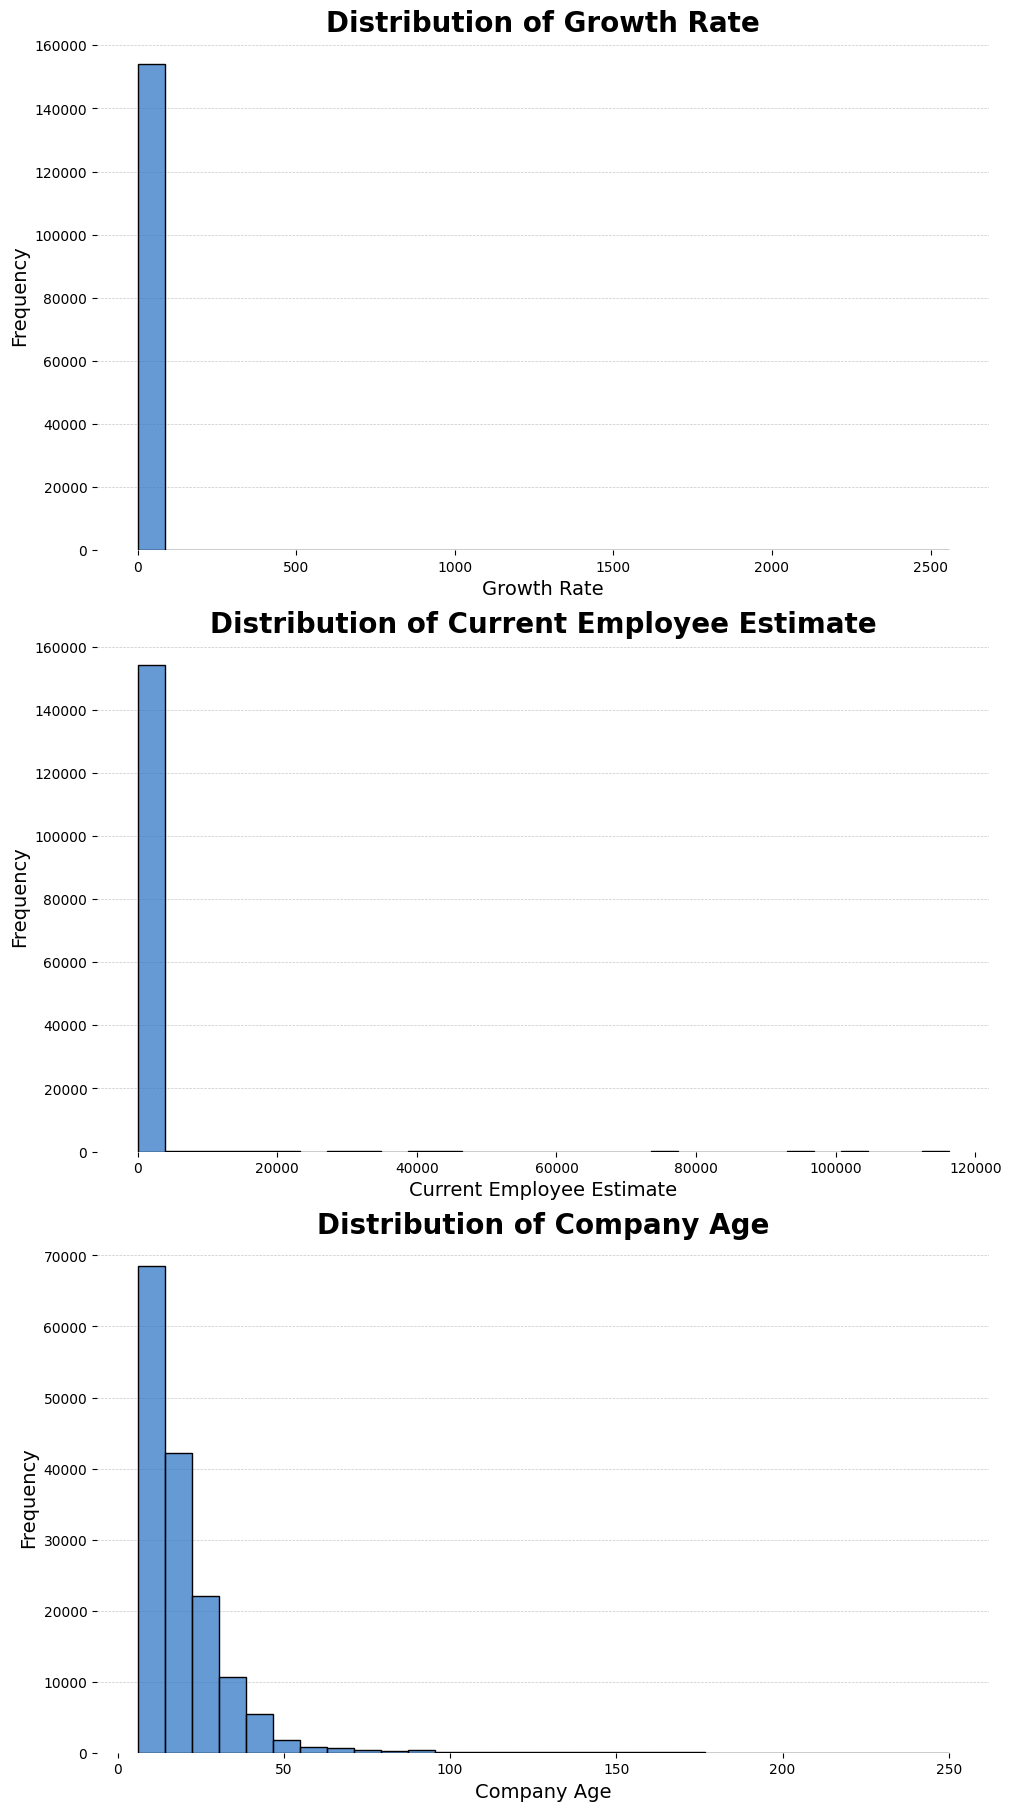

In [19]:
# Create figure and axes, one subplot per feature, stacked vertically
fig, axes = plt.subplots(len(features), 1, figsize=(10, 6 * len(features)), constrained_layout=True)

# Plot histogram for each feature
for ax, feature in zip(axes, features):
    sns.histplot(data[feature], bins=30, kde=False, color="#3178c6", edgecolor="black", alpha=0.75, ax=ax)
    ax.set_title(f"Distribution of {feature.replace('_', ' ').title()}", fontsize=20, fontweight='600')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)
# Adjust the overall figure background color to white
fig.patch.set_facecolor('#ffffff')
plt.show()

The histograms showed that all three features are **highly right-skewed**, with a majority of values concentrated near zero and long tails of extreme values.

To prepare the data for dimensionality reduction and clustering, we applied the following transformations:

1. Capping (Winsorization):
    We capped extreme outliers at the `99th percentile` to reduce the effect of extreme values without fully removing them.
2. Log Transformation:
    We applied `log(1 + x)` to all three features to reduce skewness and compress the right tail, improving feature scaling and cluster separation.
3. Standard Scaling:
    We standardized the transformed features using `StandardScaler` to ensure zero mean and unit variance before applying PCA and KMeans.

In [20]:
df_cluster = data[features].copy()

In [21]:
## 1. Cap extreme values
for feature in features:
    df_cluster[feature] = df_cluster[feature].clip(upper=df_cluster[feature].quantile(0.99))

## 2. Apply log(1 + x) to reduce skew
for feature in features:
    df_cluster[feature] = np.log1p(df_cluster[feature])

## 3. Scale (for PCA + KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


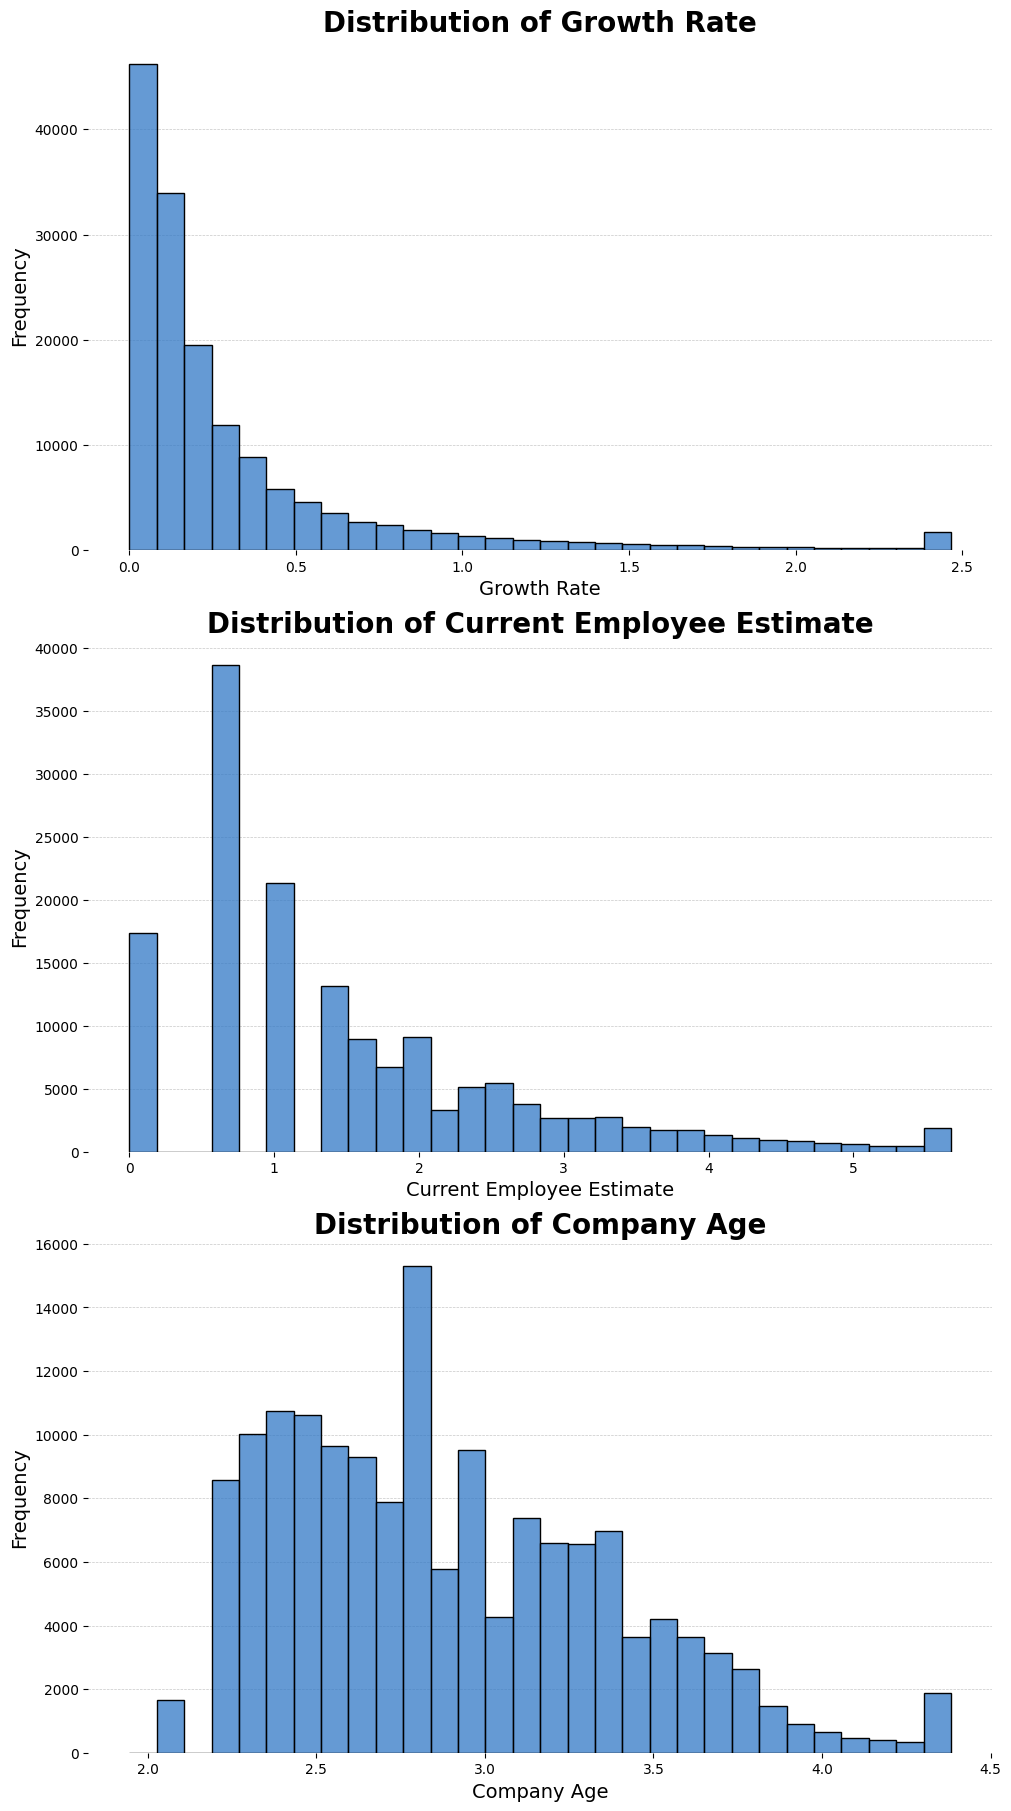

In [22]:
# Create figure and axes, one subplot per feature, stacked vertically
fig, axes = plt.subplots(len(features), 1, figsize=(10, 6 * len(features)), constrained_layout=True)

# Plot histogram for each feature
for ax, feature in zip(axes, features):
    sns.histplot(df_cluster[feature], bins=30, kde=False, color="#3178c6", edgecolor="black", alpha=0.75, ax=ax)
    ax.set_title(f"Distribution of {feature.replace('_', ' ').title()}", fontsize=20, fontweight='600')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)
# Adjust the overall figure background color to white
fig.patch.set_facecolor('#ffffff')
plt.show()

As we can see from the distributions, features now have a normalized distributions, which are better suited for distance-based algorithms like KMeans and dimensionality reduction techniques like PCA.

## PCA for Visualization

PCA reduce the 3D feature space to 2D for cluster visualization. The components reflect general patterns of:
- **PCA1**: AI-readiness (growth, small team)
- **PCA2**: Age or operational depth


In [23]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

## KMeans Clustering

We will use `KMeans` on:

- Scaled Growth
- Size
- Maturity


In [24]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

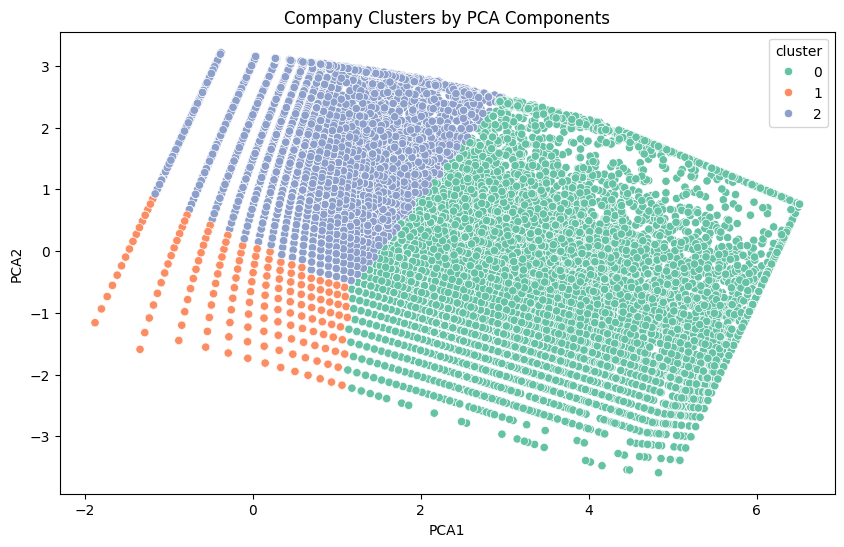

In [25]:
## Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set2')
plt.title('Company Clusters by PCA Components')
plt.show()

Interpretation:

Cluster 0: Companies with strong scaling signals and AI-readiness potential.

Cluster 1: Smaller, possibly early-stage or niche firms with limited AI alignment.

Cluster 2: Mature companies with moderate growth but less urgency for AI adoption.

In [26]:
## Cluster Profiles
df_cluster.groupby('cluster')[features].mean()

,growth_rate,current_employee_estimate,company_age
cluster,,,
0,1.306959,4.009375,3.115775
1,0.175404,0.995705,2.566802
2,0.196577,1.675459,3.390095


### Cluster Profiles

We performed KMeans clustering and analyzed the average values of three key features (`growth_rate`, `current_employee_estimate`, and `company_age`) across each cluster. This analysis helps in interpreting the nature of the grouped companies.

| Cluster | Growth Rate | Employee Estimate | Company Age | Summary |
|---------|-------------|-------------------|--------------|---------|
| **0**   | **1.31**    | **4.01**          | 3.12         | High-growth, larger companies – likely more AI-ready |
| **1**   | 0.18        | 1.00              | 2.57         | Small and younger companies – early stage, startups |
| **2**   | 0.20        | 1.68              | **3.39**     | More mature companies with moderate growth |

### Key Insights:
- 🟢 **Cluster 0** represents companies with the highest growth and employee count, potentially the most AI-ready.
- 🟠 **Cluster 1** consists of smaller, younger firms—ideal for targeting with lightweight or introductory AI solutions.
- 🔵 **Cluster 2** includes older, moderately staffed companies—likely stable but less agile.

This profile-based segmentation allows us to tailor strategies for AI outreach, tool adoption, or investment recommendations based on the maturity and scale of each group.


Focus outreach or modeling efforts primarily on Cluster 0.

If doing segmented marketing or personalized recommendations, tailor different approaches:

Cluster 0 → ROI-based AI use cases.

Cluster 2 → Emphasize modernization, cost-cutting, or catching up.

Cluster 1 → Focus on affordable, lightweight tools if targeting them at all.

In [27]:
## Assign cluster to our original data
data['cluster'] = df_cluster['cluster']

## Top Lead Extraction Strategy

To prioritize high-potential companies for AI solution outreach, we identify the **global top 5% leads** based on the `lead_score` metric. This score reflects a composite indicator of company readiness and potential for AI adoption.

The following steps were taken:

1. **Global Top 5% Threshold**: We computed the 95th percentile of all `lead_score` values to establish a threshold for the top 5% of companies.
2. **Top Leads Selection**: Companies with a `lead_score` above this threshold were selected as top global leads.
3. **Cluster-Specific Filtering**: From these top leads, we further filtered for companies belonging to a specific cluster (e.g., **Cluster 0**) – the segment associated with high growth and employee size, hence ideal AI adopters.

This refined filtering enables **targeted outreach to high-value companies** within strategically important segments.



In [28]:
## Global top 5% threshold
threshold = data['lead_score'].quantile(0.95)

## Filter top leads globally
top_5_percent = data[data['lead_score'] >= threshold]

## Further filter by cluster (e.g., cluster 0)
top_leads = top_5_percent[top_5_percent['cluster'] == 0]

In [29]:
top_leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 46417 to 401867
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       7711 non-null   object 
 1   domain                     7502 non-null   object 
 2   year_founded               7711 non-null   float64
 3   industry                   7711 non-null   object 
 4   size_range                 7711 non-null   object 
 5   locality                   7711 non-null   object 
 6   country                    7711 non-null   object 
 7   linkedin_url               7711 non-null   object 
 8   current_employee_estimate  7711 non-null   int64  
 9   company_age                7711 non-null   float64
 10  growth_rate                7711 non-null   float64
 11  lead_score                 7711 non-null   float64
 12  cluster                    7711 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(7)
me

In [30]:
relevant_columns  = ['name', 'domain', 'linkedin_url', 'industry', 'locality', 'country', 
                     'current_employee_estimate', 'company_age', 'growth_rate', 
                     'lead_score']
top_leads = top_leads[relevant_columns]

In [ ]:
top_leads.to_csv('top_ai_ready_leads.csv', index = False)

## Conclusion 

Through clustering and lead scoring, we have effectively segmented the AI company landscape and identified high-potential targets. Specifically:

- **Cluster 0** emerges as the most promising segment, characterized by the highest average growth rate and employee count — key indicators of scalability and readiness for AI-driven solutions.
- By applying a **global top 5% lead scoring threshold**, we isolate the most strategic opportunities across all clusters.
- Further narrowing down to top leads within Cluster 0 allows us to focus on companies that not only show high potential but also align with the characteristics of high-growth, AI-adopting firms.

This approach enables **precision targeting** in marketing, partnership development, or business expansion, ensuring resources are directed where they are most likely to yield ROI.


## Next Steps

While this analysis provides valuable insights into AI company segmentation and lead prioritization, further steps could significantly enhance the pipeline:

- **Web Scraping for Enrichment**: Automate data collection from company websites, Crunchbase, or LinkedIn to extract additional features such as:
  - AI product offerings
  - Recent funding rounds
  - Tech stack or job postings
- **Real-Time Lead Monitoring**: Develop a scheduled scraping pipeline to track changes in employee growth, news mentions, or funding updates.
- **Expand Lead Scoring Model**: Incorporate additional data (social signals, web traffic, patents, etc.) into the scoring mechanism for better prioritization.
- **Deploy as a Streamlit App with Scheduler**: Extend the existing app to include periodic data updates and scraping, enabling real-time dashboards and alerts for high-potential leads.

These steps would transform the current static analysis into a dynamic, continuously improving lead qualification system.
